# Train data processing

Written by - Chandrima Chakrabarty (28-5-2021)  chakrabartychandrima91@gmail.com 

In [43]:
#importing required libreries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.utils import class_weight
from sklearn import preprocessing

### Data Processing & Feature Engineering

In [44]:
train = pd.read_csv('train_s3TEQDk.csv')
print(train.shape)
#train.head()

(245725, 11)


##### Bifurcate in different age classes

In [45]:
age_ = train.Age.values
age_class = []
for element in age_:
    if element >= 70:
        age_class.append(0)
    if ((element >= 60) & (element <70)):
        age_class.append(1)
    if ((element >= 50) & (element <60)):
        age_class.append(3)
    if ((element >= 40) & (element <50)):
        age_class.append(5)
    if ((element >= 30) & (element <40)):
        age_class.append(6)
    if ((element >= 20) & (element <30)):
        age_class.append(4)
    if ((element >= 0) & (element <20)):
        age_class.append(2)
        
train['age_class'] = age_class

In [46]:
train['new_var1'] = ((train['Age']*12)*train['Vintage']) #Creating new feature

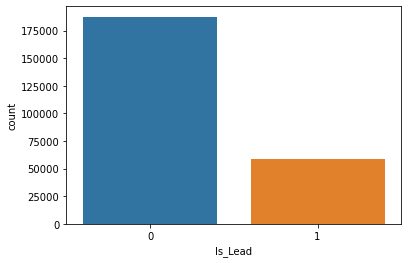

In [47]:
sns.countplot(x='Is_Lead',data=train)
plt.show()

**Filling missing values**

In [48]:
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
age_class                  0
new_var1                   0
dtype: int64

In [49]:
cols_with_missing = [col for col in train.columns if train[col].isnull().any()]
print('Columns with Missing values : ')
cols_with_missing

Columns with Missing values : 


['Credit_Product']

In [50]:
#Adding new columns to give the information about missing rows
for col in cols_with_missing:
  train[col + '_was_missing'] = train[col].isnull()
  train[col + '_was_missing'] = train[col + '_was_missing'].apply(lambda x: 1 if x==True else 0)

In [51]:
train

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,age_class,new_var1,Credit_Product_was_missing
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0,0,37668,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0,6,11520,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0,3,17472,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0,6,7752,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0,6,11880,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0,3,66708,1
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0,4,4860,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0,4,4056,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0,4,10416,0


In [52]:
#Filling missing values with a new category 'X'

train['Credit_Product'].fillna('X',inplace=True)

In [53]:
train.isnull().sum().sum()

0

In [54]:
#Making a copies of original data

train_org=train.copy()

In [55]:
## Convert NAN's in Credit_Product as 0,'No' as 1 and 'Yes' as 1
train['Credit_Product']=train['Credit_Product'].apply(lambda x : str(x) if x!='X' else 0)
train['Credit_Product']=train['Credit_Product'].apply(lambda x : 1 if x!='No' else 2)

train = train.drop(['ID'],axis=1)

In [56]:
# #label encoding objects types to bring its value between 0-1

pe                = preprocessing.LabelEncoder()
train.Region_Code = pe.fit_transform(train.Region_Code)

In [57]:
train = pd.get_dummies(train,drop_first=True)

train['Avg_Account_Balance'] = np.log(train['Avg_Account_Balance'])

In [58]:
train

,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Lead,age_class,new_var1,Credit_Product_was_missing,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Is_Active_Yes
0,73,18,43,2,13.860193,0,0,37668,0,0,1,0,0,0,1,0,0
1,30,27,32,2,13.274205,0,6,11520,0,0,0,1,0,0,0,0,0
2,56,18,26,2,14.210464,0,3,17472,0,0,0,0,1,0,1,0,1
3,34,20,19,2,13.061453,0,6,7752,0,1,0,1,0,0,0,0,0
4,30,32,33,2,13.695360,0,6,11880,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245720,51,34,109,1,14.470741,0,3,66708,1,1,0,0,1,0,1,0,0
245721,27,18,15,2,13.668114,0,4,4860,0,1,0,1,0,0,0,0,1
245722,26,31,13,2,13.416016,0,4,4056,0,0,0,1,0,0,0,0,0
245723,28,23,31,2,12.917806,0,4,10416,0,0,0,1,0,0,0,0,0


##### Introduce new variable

In [59]:
train['new_var2'] = train['Gender_Male']*train['Occupation_Salaried']

In [60]:
#bringing column value in the range 0 to 1 

train['Avg_Account_Balance'] = train['Avg_Account_Balance']/train['Avg_Account_Balance'].abs().max()
train['Vintage']             = train['Vintage']/train['Vintage'].abs().max()
train['Age']                 = train['Age']/train['Age'].abs().max()
train['new_var1']            = train['new_var1'] /train['new_var1'].abs().max()
train['Region_Code']         = train['Region_Code'] /train['Region_Code'].abs().max()
train['Credit_Product']      = train['Credit_Product'] /train['Credit_Product'].abs().max()

train['age_class']           = train['age_class']/train['age_class'].abs().max()
train['new_var2']            = train['new_var2'] /train['new_var2'].abs().max()

In [61]:
train

,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Lead,age_class,new_var1,Credit_Product_was_missing,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Is_Active_Yes,new_var2
0,0.858824,0.529412,0.318519,1.0,0.858073,0,0.000000,0.273551,0,0,1,0,0,0,1,0,0,0.0
1,0.352941,0.794118,0.237037,1.0,0.821795,0,1.000000,0.083660,0,0,0,1,0,0,0,0,0,0.0
2,0.658824,0.529412,0.192593,1.0,0.879758,0,0.500000,0.126885,0,0,0,0,1,0,1,0,1,0.0
3,0.400000,0.588235,0.140741,1.0,0.808624,0,1.000000,0.056296,0,1,0,1,0,0,0,0,0,1.0
4,0.352941,0.941176,0.244444,1.0,0.847869,0,1.000000,0.086275,0,0,0,1,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245720,0.600000,1.000000,0.807407,0.5,0.895872,0,0.500000,0.484444,1,1,0,0,1,0,1,0,0,0.0
245721,0.317647,0.529412,0.111111,1.0,0.846182,0,0.666667,0.035294,0,1,0,1,0,0,0,0,1,1.0
245722,0.305882,0.911765,0.096296,1.0,0.830575,0,0.666667,0.029455,0,0,0,1,0,0,0,0,0,0.0
245723,0.329412,0.676471,0.229630,1.0,0.799731,0,0.666667,0.075643,0,0,0,1,0,0,0,0,0,0.0


In [62]:
from sklearn.decomposition import PCA

train_fe = train

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(train_fe[['Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance']])

# update dataframe 
train_fe = pd.concat((train_fe, pd.DataFrame(ugriz)), axis=1)
train_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
#train_fe.drop(['Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance'], axis=1, inplace=True)
train_fe.head()

,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Lead,age_class,new_var1,Credit_Product_was_missing,Gender_Male,...,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Is_Active_Yes,new_var2,PCA_1,PCA_2,PCA_3
0,0.858824,0.529412,0.318519,1.0,0.858073,0,0.0,0.273551,0,0,...,0,0,0,1,0,0,0.0,-0.001112,0.162043,0.308621
1,0.352941,0.794118,0.237037,1.0,0.821795,0,1.0,0.083660,0,0,...,1,0,0,0,0,0,0.0,-0.138126,-0.238522,-0.083739
2,0.658824,0.529412,0.192593,1.0,0.879758,0,0.5,0.126885,0,0,...,0,1,0,1,0,1,0.0,0.068662,-0.036948,0.203406
3,0.400000,0.588235,0.140741,1.0,0.808624,0,1.0,0.056296,0,1,...,1,0,0,0,0,0,1.0,0.074660,-0.226338,0.008580
4,0.352941,0.941176,0.244444,1.0,0.847869,0,1.0,0.086275,0,0,...,1,0,0,0,0,0,0.0,-0.279568,-0.280007,-0.089000


In [63]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

scaler = MinMaxScaler()
sdss   = scaler.fit_transform(train_fe[['PCA_1','PCA_2','PCA_3']])

train_fe[['PCA_1','PCA_2','PCA_3']] = sdss

In [64]:
train = train_fe.copy()

In [65]:
X_train=train.drop(['Is_Lead'],axis=1)
y_train=train[['Is_Lead']]

In [66]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


over  = SMOTE(sampling_strategy=0.60)
#under = RandomUnderSampler(sampling_strategy=0.10)
#steps = [('o', over), ('u', under)]#,('model', model)]
#pipeline = Pipeline(steps=steps)
# transform the dataset
X_sm, y_sm = over.fit_resample(X_train, y_train)

X_train = X_sm
y_train = y_sm

In [ ]:
%store X_train
%store y_train